In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [3]:
# 데이터 로드
train = pd.read_csv("data-files/train.csv")
test = pd.read_csv("data-files/test.csv")
submission = pd.read_csv("data-files/sample_submission.csv")

In [4]:
# 타겟 및 피처 분리
y_train = train["성공확률"]
X_train = train.drop(columns=["ID", "성공확률"])
X_test = test.drop(columns=["ID"])

In [5]:
# 기업나이 생성
X_train["기업나이"] = 2025 - X_train["설립연도"]
X_test["기업나이"] = 2025 - X_test["설립연도"]
X_train.drop(columns=["설립연도"], inplace=True)
X_test.drop(columns=["설립연도"], inplace=True)

In [6]:
# 범주형 인코딩
cat_cols = X_train.select_dtypes(include="object").columns
for col in cat_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))

In [7]:
# 결측치 처리
for col in ['직원 수', '고객수(백만명)']:
    X_train[col] = X_train[col].fillna(X_train[col].mean())
    X_test[col] = X_test[col].fillna(X_test[col].mean())

In [8]:
# 파생 변수 생성

X_train['매출_투자비'] = X_train['연매출(억원)'] / (X_train['총 투자금(억원)'] + 1)
X_test['매출_투자비'] = X_test['연매출(억원)'] / (X_test['총 투자금(억원)'] + 1)

X_train['고객당매출'] = X_train['연매출(억원)'] / (X_train['고객수(백만명)'] + 1)
X_test['고객당매출'] = X_test['연매출(억원)'] / (X_test['고객수(백만명)'] + 1)

X_train['SNS_비율'] = X_train['SNS 팔로워 수(백만명)'] / (X_train['고객수(백만명)'] + 1)
X_test['SNS_비율'] = X_test['SNS 팔로워 수(백만명)'] / (X_test['고객수(백만명)'] + 1)

X_train["is_핀테크_Seed"] = ((X_train["분야"] == "핀테크") & (X_train["투자단계"] == "Seed")).astype(int)
X_test["is_핀테크_Seed"] = ((X_test["분야"] == "핀테크") & (X_test["투자단계"] == "Seed")).astype(int)


In [9]:
# 모델 정의 (튜닝 반영)
lgb = LGBMRegressor(
    n_estimators=1500,
    learning_rate=0.01,
    max_depth=10,
    num_leaves=31,
    random_state=42,
    n_jobs=-1
)

In [10]:
xgb = XGBRegressor(
    n_estimators=1500,
    learning_rate=0.01,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=0,
    n_jobs=-1
)

In [11]:
cat = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.02,
    depth=8,
    random_state=42,
    verbose=0
)

In [12]:
# 모델 학습
lgb.fit(X_train, y_train)
xgb.fit(X_train, y_train)
cat.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1932
[LightGBM] [Info] Number of data points in the train set: 4376, number of used features: 15
[LightGBM] [Info] Start training from score 0.537340
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

In [13]:
# 예측
lgb_pred = lgb.predict(X_test)
xgb_pred = xgb.predict(X_test)
cat_pred = cat.predict(X_test)

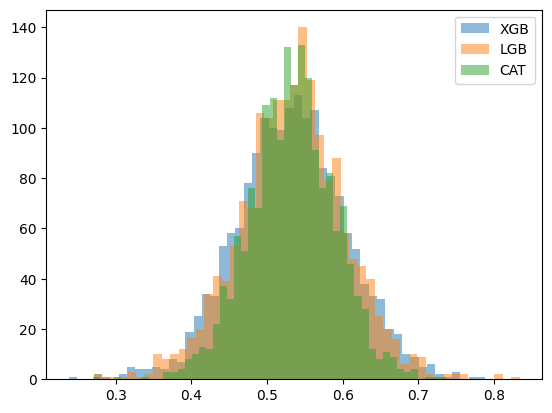

In [14]:
import matplotlib.pyplot as plt
plt.hist(xgb.predict(X_test), bins=50, alpha=0.5, label='XGB')
plt.hist(lgb.predict(X_test), bins=50, alpha=0.5, label='LGB')
plt.hist(cat.predict(X_test), bins=50, alpha=0.5, label='CAT')
plt.legend()
plt.show()

In [15]:
X_train.iloc[597]

국가                    8.000000
분야                    9.000000
투자단계                  2.000000
직원 수               4390.000000
인수여부                  0.000000
상장여부                  1.000000
고객수(백만명)             85.000000
총 투자금(억원)          3106.000000
연매출(억원)           11023.000000
SNS 팔로워 수(백만명)        3.000000
기업가치(백억원)             3.000000
기업나이                 14.000000
매출_투자비                3.547795
고객당매출               128.174419
SNS_비율                0.034884
is_핀테크_Seed           0.000000
Name: 597, dtype: float64

In [16]:
diff_df = pd.DataFrame({
    "XGB": xgb_pred,
    "LGB": lgb_pred,
    "CAT": cat_pred
})
diff_df["std"] = diff_df.std(axis=1)
outliers = diff_df.sort_values("std", ascending=False).head(20)
print(outliers)

           XGB       LGB       CAT       std
597   0.523930  0.410878  0.592042  0.091506
651   0.323917  0.431244  0.500989  0.089198
1330  0.670690  0.833731  0.695031  0.087951
1586  0.530575  0.656319  0.490348  0.086580
1578  0.463628  0.607840  0.452943  0.086510
62    0.502771  0.368691  0.530103  0.086389
1231  0.585573  0.750175  0.631940  0.084875
866   0.453252  0.585519  0.604757  0.082481
1536  0.493970  0.464214  0.614620  0.079649
1104  0.691983  0.539979  0.576184  0.079400
590   0.314779  0.403979  0.472683  0.079174
1226  0.446203  0.354954  0.512343  0.079028
592   0.477681  0.572229  0.629487  0.076663
1498  0.667479  0.638416  0.523498  0.076137
1236  0.516865  0.378598  0.498986  0.075200
55    0.569167  0.659825  0.510682  0.075147
1385  0.452818  0.499773  0.599489  0.074901
598   0.694982  0.808689  0.668191  0.074596
73    0.495048  0.638300  0.532406  0.074308
994   0.279410  0.270821  0.403176  0.074060


In [17]:
# Soft voting (평균 앙상블)
# final_pred = (lgb_pred + xgb_pred + cat_pred) / 3
final_pred = (
    xgb_pred * 0.85 +    # 가장 성능 좋았던 XGB에 가장 많은 가중치
    lgb_pred * 0.05 +
    cat_pred * 0.10
)
final_pred = np.clip(final_pred, 0, 1)  # 성공확률은 0~1 범위

In [ ]:
# outlier_indices = outliers.index
# for idx in outlier_indices:
#     preds = [xgb_pred[idx], lgb_pred[idx], cat_pred[idx]]
#     final_pred[idx] = np.median(preds)

In [18]:
outlier_indices = outliers.index
for idx in outlier_indices:
    final_pred[idx] = (
        # 0.7 * 
        xgb_pred[idx]
        # + 0.1 * lgb_pred[idx] +
        # 0.2 * cat_pred[idx]
    )

In [19]:
submission["성공확률"] = final_pred
submission.to_csv("submission_best_ensemble12.csv", index=False)

In [36]:
submission.iloc[597]

ID      TEST_0597
성공확률     0.526247
Name: 597, dtype: object